# Simulating Language, Lab 2, Word learning

We are going to start with a very simple model, of a Bayesian learner learning the meaning of a single word. This model is a simplification of the model in Tenenbaum (2000), which is a simpler version of the model in Xu & Tenenbaum (2007): in other words, it's pretty simple, but allows us to illustrate some of the same principles. It's also our first Bayesian model, so if you haven't seen one of these before then starting with a relatively simple one will help!

## Representing word meanings

We are going to assume that the meaning of a word is the set of things that word refers to, and to make things even easier for ourselves, we are going to model "things that words refer to" as numbers. So a word meaning is just a set of numbers, representing the set of entities that the word can be used to refer to. 

Python gives us some handy notation for dealing with sets: sets look a bit like lists, but they are enclosed in curly brackets, they are unordered, and they can't contain duplicates. So the following code represents (in Python) the meaning of a word which can be used to refer to three things, entities 1, 2 and 7. 

```Python
word_meaning = {1,2,7}
```
You'll have to use your imagination to decide what entities 1, 2 and 7 are! Maybe this word is a noun and these are the objects in the world it can refer to, or maybe it's a verb and these are actions it can be used to describe. 

Using this notation, how would you represent a word with a very specific meaning, referring only to entity 99? How would you represent the meaning of a word that refers to entities 0, 1, 2, 3, and 4? What happens if you try to create a word meaning that contains a duplicate entity?


arithmetic combination of numbers?

## The code

Now we've introduced the notation we are going to be using to represent word meanings we can get on and build the model. We'll start by loading the `prod()` function from the numpy library (we will use it for multiplying a list of numbers, it saves us writing our own function). We also have to load the plotting library and set up inline plots. Every model we look at will start with a block of code like this that loads some libraries and sets up plotting.

In [10]:
from numpy import prod

%matplotlib inline
import matplotlib.pyplot as plt

### A useful function for normalizing with probabilities

We are also going to define a utility function, `normalize_probs()`, which takes a list of numbers and normalizes them for us (i.e. scales them so they sum to 1) – we are going to use this at various points to make sure the numbers we are dealing with are genuine probabilities and behave nicely. This function is used elsewhere in the code, but it is not particularly important that you understand exactly how it works so you can skip over it if you want.

In [11]:
def normalize_probs(probs):
    """Takes a list of numbers; returns a list of scaled versions of those numbers that, together, sum to 1."""
    total = sum(probs)  # calculates the summed probabilities
    normedprobs = []
    for p in probs:
        normedprobs.append(p / total)  # normalise by dividing by summed probs
    return normedprobs

### The hypothesis space
As outlined above, word meanings are sets. Our learner is going to receive some data, that is, some examples of the word they are trying to learn being used to refer to entities in the world. Then they will use Bayesian inference to infer the word's meaning, that is, the set of entities the word can be used to refer to.

To make this model work, we have to lay out the candidate word meanings our learner considers: this is the *hypothesis space*. Our learner will consider each of the hypotheses (candidate word meanings) in the hypothesis space and calculate its posterior probability given the data they have seen.

The hypothesis space is therefore a collection of word meanings that the learner considers when learning. We'll represent the hypothesis space in Python as a list of word meanings. So here's how we represent the hypothesis space for a learner who thinks there are two candidate meanings for the word they are learning: either it refers to entity 0 and entity 1, or it refers to entity 2.

```Python
toy_hypothesis_space = [{0,1},{2}]
```

How would you represent the following hypothesis space: "either the word refers to entity 0, or it refers to entities 2 through 4, or it refers to entity 5"?  

In [12]:
{0},{2,3,4},{5}
# how does {a,b} vs {a},{b} work in natural language?

({0}, {2, 3, 4}, {5})

You could make the set of entities and the list of possible hypotheses as complex as you want, but for this model we are going to start out by making things fairly small (and just big enough to illustrate the things we want to illustrate). 
- We'll assume there are 11 possible entities in the world, numbered 0 to 10.
- We'll assume that the word refers to between 1 and 6 entities (i.e. it doesn't refer to the empty set, it doesn't refer to everything).
- We'll assume that words refer to entities that are clustered in the space of possible entities, as represented by consecutive numbers. This is a bit arbitrary and we'll return to this assumption below!

Under those assumptions, this is our hypothesis space:

In [13]:
all_hypotheses = [{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},
         {0,1},{1,2},{2,3},{3,4},{4,5},{5,6},{6,7},{7,8},{8,9},{9,10},
         {0,1,2},{1,2,3},{2,3,4},{3,4,5},{4,5,6},{5,6,7},{6,7,8},{7,8,9},{8,9,10},
         {0,1,2,3},{1,2,3,4},{2,3,4,5},{3,4,5,6},{4,5,6,7},{5,6,7,8},{6,7,8,9},{7,8,9,10},
         {0,1,2,3,4},{1,2,3,4,5},{2,3,4,5,6},{3,4,5,6,7},{4,5,6,7,8},{5,6,7,8,9},{6,7,8,9,10},
         {0,1,2,3,4,5},{1,2,3,4,5,6},{2,3,4,5,6,7},{3,4,5,6,7,8},{4,5,6,7,8,9},{5,6,7,8,9,10}]

Notice that we are just enumerating the hypotheses by hand, rather than writing a function to generate this list for us. Let's have a look at these hypotheses, by typing `all_hypotheses` in the cell below. 

In [14]:
all_hypotheses

[{0},
 {1},
 {2},
 {3},
 {4},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {0, 1},
 {1, 2},
 {2, 3},
 {3, 4},
 {4, 5},
 {5, 6},
 {6, 7},
 {7, 8},
 {8, 9},
 {9, 10},
 {0, 1, 2},
 {1, 2, 3},
 {2, 3, 4},
 {3, 4, 5},
 {4, 5, 6},
 {5, 6, 7},
 {6, 7, 8},
 {7, 8, 9},
 {8, 9, 10},
 {0, 1, 2, 3},
 {1, 2, 3, 4},
 {2, 3, 4, 5},
 {3, 4, 5, 6},
 {4, 5, 6, 7},
 {5, 6, 7, 8},
 {6, 7, 8, 9},
 {7, 8, 9, 10},
 {0, 1, 2, 3, 4},
 {1, 2, 3, 4, 5},
 {2, 3, 4, 5, 6},
 {3, 4, 5, 6, 7},
 {4, 5, 6, 7, 8},
 {5, 6, 7, 8, 9},
 {6, 7, 8, 9, 10},
 {0, 1, 2, 3, 4, 5},
 {1, 2, 3, 4, 5, 6},
 {2, 3, 4, 5, 6, 7},
 {3, 4, 5, 6, 7, 8},
 {4, 5, 6, 7, 8, 9},
 {5, 6, 7, 8, 9, 10}]

Can you see the hypotheses that have specific meanings? How many are there? How many candidate word meanings have the broadest, most general meaning? If this is our hypothesis space, would a learner ever consider the possibility that a word had a meaning like "this word refers to entity 0 or entity 5, but nothing else"?

the first 11 sets have specific meanings. there are 6 sets with 6 meanings. if a learner considers a word refer to either 0 or 5, the hypothesis space look like {0,5}

### The prior
Now we have our space of hypotheses the word learner is going to consider, we need to specify two quantities to do Bayesian inference: 
- the prior probability of each hypothesis (i.e. before I have seen any data, how likely is it that the word will have this meaning?)
- the likelihood of the data given each hypothesis (i.e. if this candidate word meaning was the word's *true* meaning, how likely would it be to generate the data I saw?). 

We'll do the prior first, since it's very simple: we'll just assume that all word meanings are *a priori* equally likely. In other words, our learner is going to assume, before they have seen any data, that every candidate word meaning in their hypothesis space is an equally good candidate, an equally likely possible word meaning. 

The way we are doing this in Python is to write a function, `calculate_prior()`, which works through a list of hypotheses and assigns each hypothesis equal weight: it just returns a list of prior probabilities, one per hypothesis. 

In [15]:
def calculate_prior(possible_hypotheses): # uniform equal prior
    """Takes list of sets; returns list of probabilities with one probability per set."""
    prior = []  # going to put our prior probabilities here
    for h in possible_hypotheses:  # for each hypothesis
        prior.append(1/len(possible_hypotheses))  #assign it 1/number-of-hypotheses prior probability
    return prior  # return the list when finished

Inspect the prior over our hypothesis space (by running `calculate_prior(all_hypotheses)`). Do the numbers you see there make sense? 

In [16]:
calculate_prior(all_hypotheses) # the priors calculated by 1/len are all the same

[0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431372549,
 0.0196078431

### The likelihood
Next up, the likelihood: for each candidate word meaning, how likely is it to generate a particular sample of data? In our case we are learning a single word, so our data consists of a sequence of labelling events, where on each labelling event we see the word being used to refer to an entity. We'll represent those sequences of labelling events as a list of numbers, where each element in the list is the entity that the word was referring to on a given labelling event. So for example, if I see the word being used to refer to entity 3 then entity 0, my data looks like this:
```Python
my_data = [3,0]
```
And if I see the word being used to label entity 7 five times in a row then entity 9 once, my data will look like this:
```Python
my_other_data = [7,7,7,7,7,9]
```
How would the following sequence of exposures be represented? I see the word being used to refer to entity 0, then entity 3, then entity 1, then entity 0 again.

In [17]:
[0,3,1,0]

[0, 3, 1, 0]

Now we have a way of representing data we can calculate the likelihood of a given set of data (a sequence of labellings) given a particular hypothesis about the word's meaning. We'll make two assumptions about labelling:
- We'll assume that words can only be used to label entities included in the word meaning (i.e. the word with meaning `{0,1}` can only be used to label entities 0 and 1, never entity 2, 3, etc.)
- We'll assume that the **word is equally likely to be used to label any entity included in its meaning** (i.e. the word with meaning `{0, 1}` is equally likely to be used to label entity 0 and entity 1; there is no privileged meaning that it's most likely to be used for). 

Again, these are assumptions – we could build the model differently, to embody a different set of assumptions encapsulating a different theory of how words work!

Under those assumptions, `likelihood()` calculates the likelihood of some data (a sequence of observations of labellings) for a specific hypothesis: it works through a list of data, calculating the probability of each labelling event, then the overall likelihood of the sequence of exposures is just the product of those probabilities (i.e. we multiply all the individual probabilities).

In [18]:
def likelihood(data,hypothesis):
    """Takes data (list of numbers) and hypothesis (set of numbers);
       returns the probability of the given hypothesis generating the observed data."""
    likelihoods = [] #going to store the probability of each observation here
    for data_item in data: #work through the data
        if data_item in hypothesis: #if that labelling can be generated under this candidate word meaning
            likelihood_this_item = 1/len(hypothesis) #its probability is 1/length-of-the-hypothesis
        else: #if that labelling *cannot* be generated under this candidate word meaning
            likelihood_this_item = 0 #its probability is 0
        likelihoods.append(likelihood_this_item)
    return prod(likelihoods) #when you have all the individual likelihoods, multiply them all together

What's the likelihood of observing the word being used to label entity 0 once if the word's meaning is `{0,1}`? Hint: you can calculate this using `likelihood([0],{0,1})`. What's the likelihood of seeing the word being used to label entity 0 twice and entity 1 once, if the word's meaning is `{0,1}`? What's the likelihood of that same data if the word's meaning is `{0,1,2,3}`? Why the difference?

In [35]:
likelihood([0],{0,1})

np.float64(0.5)

1/2, 1/3, 1/4

if the data contains any observation not present in the meaning, likelihood will be zero

In [20]:
# likelihood([1,2],{0,1,2})
# 1/9

### The posterior
Finally we are in a position to be able to calculate the posterior: our learner receives some data, we work through our hypothesis space (our set of candidate word meanings) and calculate the posterior probability of each hypothesis given that data. We do this by applying Bayes' Rule: the posterior probability of hypothesis $h$ given data $d$ is proportional to the likelihood of $d$ given $h$ times the prior probability of $h$. Or, in maths, $p(h|d)\propto p(d|h) p(h)$. We have already defined our prior and the likelihood, so all we have to do is work through the hypothesis space and calculate this product for each hypothesis; then, at the end, we normalise these numbers, which turns them into probabilities (this is the equivalent of calculating $p(d)$, which is the denominator of Bayes' Rule). 

In [21]:
def posterior(data,possible_hypotheses,prior):
    """Takes data (list of numbers), possible_hypotheses (list of sets), prior (list of probabilities);
       returns list of probabilities, one per hypothesis."""
    posteriors = []  # this will hold the posterior distribution
    for i in range(len(possible_hypotheses)):  # consider each possible hypothesis in turn
        h = possible_hypotheses[i]  # look up the hypothesis 
        prior_h = prior[i]  # look up its prior 
        likelihood_h = likelihood(data,h)  # calculate likelihood of data given this hypothesis
        posterior_h = prior_h * likelihood_h  # multiply prior x likelihood
        posteriors.append(posterior_h)  # add it to the growing list
    return normalize_probs(posteriors)  # finally, normalise to turn these numbers into a probability distribution
    

Use the `posterior` function to calculate the posterior probability of all hypotheses (the posterior probability distribution) given the data `[0,0,1]`. You can achieve this using the following little chunk of code.

```Python
my_prior = calculate_prior(all_hypotheses)
posterior([0,0,1],all_hypotheses,my_prior)
```
If that's a bit hard to look at, you can print out a nice list with each hypothesis and its posterior probability using a `for` loop, like this:
```Python
my_prior = calculate_prior(all_hypotheses)
my_posterior = posterior([0,0,1],all_hypotheses,my_prior)
for i in range(len(all_hypotheses)):
    print(all_hypotheses[i],my_posterior[i])
    
```
Which hypotheses (candidate word meanings) have posterior probability 0? Why? Which hypotheses have non-zero posterior probability? Which hypothesis has the highest posterior probability, and why?

In [22]:
my_prior = calculate_prior(all_hypotheses)
posts=posterior([0,0,1],all_hypotheses,my_prior)
for i in range (len(all_hypotheses)):
    print(f'{posts[i]}, {all_hypotheses[i]}')
# hypothesis lacking any observation will have posterior 0

0.0, {0}
0.0, {1}
0.0, {2}
0.0, {3}
0.0, {4}
0.0, {5}
0.0, {6}
0.0, {7}
0.0, {8}
0.0, {9}
0.0, {10}
0.6568863586599518, {0, 1}
0.0, {1, 2}
0.0, {2, 3}
0.0, {3, 4}
0.0, {4, 5}
0.0, {5, 6}
0.0, {6, 7}
0.0, {8, 7}
0.0, {8, 9}
0.0, {9, 10}
0.19463299515850427, {0, 1, 2}
0.0, {1, 2, 3}
0.0, {2, 3, 4}
0.0, {3, 4, 5}
0.0, {4, 5, 6}
0.0, {5, 6, 7}
0.0, {8, 6, 7}
0.0, {8, 9, 7}
0.0, {8, 9, 10}
0.08211079483249398, {0, 1, 2, 3}
0.0, {1, 2, 3, 4}
0.0, {2, 3, 4, 5}
0.0, {3, 4, 5, 6}
0.0, {4, 5, 6, 7}
0.0, {8, 5, 6, 7}
0.0, {8, 9, 6, 7}
0.0, {8, 9, 10, 7}
0.042040726954236926, {0, 1, 2, 3, 4}
0.0, {1, 2, 3, 4, 5}
0.0, {2, 3, 4, 5, 6}
0.0, {3, 4, 5, 6, 7}
0.0, {4, 5, 6, 7, 8}
0.0, {5, 6, 7, 8, 9}
0.0, {6, 7, 8, 9, 10}
0.024329124394813034, {0, 1, 2, 3, 4, 5}
0.0, {1, 2, 3, 4, 5, 6}
0.0, {2, 3, 4, 5, 6, 7}
0.0, {3, 4, 5, 6, 7, 8}
0.0, {4, 5, 6, 7, 8, 9}
0.0, {5, 6, 7, 8, 9, 10}


## Questions
The priority for this worksheet is to work through the in-text questions above: understanding what a hypothesis looks like in this model and how we lay out the hypothesis space, checking that the prior and likelihood functions makes sense to you, and verifying that you can compute a posterior distribution. Once you are happy with that, and if you have time left over, try these questions:
1. How does the amount of data influence the posterior distribution? For instance, is the posterior the same after seeing the data `[0,0,1]` and the data `[0,0,1,0,0,1]`?

more observations matching the hypothesis would give greater posterior

In [23]:
prior1 = calculate_prior(all_hypotheses)
print(posterior([0,0,1],all_hypotheses,prior1))
print(posterior([0,0,1,0,0,1],all_hypotheses,prior1))

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.6568863586599518), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.19463299515850427), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.08211079483249398), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.042040726954236926), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.024329124394813034), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0),

2. When are more specific word meanings preferred? When are more general word meanings preferred?

more specific word meanings refer to a smaller set such as {0,1} vs {0,1,2,3}, they are preferred when the data is small and matches all of the elements.
more general meanings are preferred to cover longer sequences in case uncovered observation yields 0 probability.

3. This code calculates a probability distribution over possible hypotheses given some data. If you had to commit to a *single* hypothesis, how would you choose one? 

choose the hypothesis that gives the highest combined posterior

4. Do we have any kind of *innateness* in our model? Are there word meanings that our model learner could never learn, no matter what kind of data we gave them? 

if the some meanings don't match the data given, they cannot be learned. if a meaning is not in the hypothesis space, but in the data, the model does not learn. 

5. [Harder] We are assuming that candidate word meanings are nice and neat: a word refers to a set of entities that are contiguous in some sense (as represented by consecutive integers: i.e. our hypothesis space includes `{3,4,5}` but not `{3,5}` as a candidate meaning). Calculate the posterior probability distribution using the standard hypothesis space and the data `[3,5]`. Which hypothesis has the highest posterior probability? Now add a "hypothesis with a hole in it", `{3,5}` to the hypothesis space and recalculate the posterior. Which hypothesis has the highest posterior probability now, and why? Is there a potential problem here if we are trying to model learning? How would we change the model to disfavour this kind of "hypothesis with a hole in it"?

In [24]:
# standard hypothesis
standard_prior = calculate_prior(all_hypotheses)
posts=posterior([3,5],all_hypotheses,standard_prior)
for i in range (len(all_hypotheses)):
    print(f'{posts[i]}, {all_hypotheses[i]}')

0.0, {0}
0.0, {1}
0.0, {2}
0.0, {3}
0.0, {4}
0.0, {5}
0.0, {6}
0.0, {7}
0.0, {8}
0.0, {9}
0.0, {10}
0.0, {0, 1}
0.0, {1, 2}
0.0, {2, 3}
0.0, {3, 4}
0.0, {4, 5}
0.0, {5, 6}
0.0, {6, 7}
0.0, {8, 7}
0.0, {8, 9}
0.0, {9, 10}
0.0, {0, 1, 2}
0.0, {1, 2, 3}
0.0, {2, 3, 4}
0.23781212841854926, {3, 4, 5}
0.0, {4, 5, 6}
0.0, {5, 6, 7}
0.0, {8, 6, 7}
0.0, {8, 9, 7}
0.0, {8, 9, 10}
0.0, {0, 1, 2, 3}
0.0, {1, 2, 3, 4}
0.13376932223543397, {2, 3, 4, 5}
0.13376932223543397, {3, 4, 5, 6}
0.0, {4, 5, 6, 7}
0.0, {8, 5, 6, 7}
0.0, {8, 9, 6, 7}
0.0, {8, 9, 10, 7}
0.0, {0, 1, 2, 3, 4}
0.08561236623067776, {1, 2, 3, 4, 5}
0.08561236623067776, {2, 3, 4, 5, 6}
0.08561236623067776, {3, 4, 5, 6, 7}
0.0, {4, 5, 6, 7, 8}
0.0, {5, 6, 7, 8, 9}
0.0, {6, 7, 8, 9, 10}
0.059453032104637316, {0, 1, 2, 3, 4, 5}
0.059453032104637316, {1, 2, 3, 4, 5, 6}
0.059453032104637316, {2, 3, 4, 5, 6, 7}
0.059453032104637316, {3, 4, 5, 6, 7, 8}
0.0, {4, 5, 6, 7, 8, 9}
0.0, {5, 6, 7, 8, 9, 10}


In [25]:
# added {3,5}
add_hyp=all_hypotheses
add_hyp.append({3,5})
prior2=calculate_prior(add_hyp)
posts2=posterior([3,5],add_hyp,prior2)
for i in range (len(add_hyp)):
    print(f'{posts2[i]}, {add_hyp[i]}')

0.0, {0}
0.0, {1}
0.0, {2}
0.0, {3}
0.0, {4}
0.0, {5}
0.0, {6}
0.0, {7}
0.0, {8}
0.0, {9}
0.0, {10}
0.0, {0, 1}
0.0, {1, 2}
0.0, {2, 3}
0.0, {3, 4}
0.0, {4, 5}
0.0, {5, 6}
0.0, {6, 7}
0.0, {8, 7}
0.0, {8, 9}
0.0, {9, 10}
0.0, {0, 1, 2}
0.0, {1, 2, 3}
0.0, {2, 3, 4}
0.1549186676994578, {3, 4, 5}
0.0, {4, 5, 6}
0.0, {5, 6, 7}
0.0, {8, 6, 7}
0.0, {8, 9, 7}
0.0, {8, 9, 10}
0.0, {0, 1, 2, 3}
0.0, {1, 2, 3, 4}
0.087141750580945, {2, 3, 4, 5}
0.087141750580945, {3, 4, 5, 6}
0.0, {4, 5, 6, 7}
0.0, {8, 5, 6, 7}
0.0, {8, 9, 6, 7}
0.0, {8, 9, 10, 7}
0.0, {0, 1, 2, 3, 4}
0.05577072037180482, {1, 2, 3, 4, 5}
0.05577072037180482, {2, 3, 4, 5, 6}
0.05577072037180482, {3, 4, 5, 6, 7}
0.0, {4, 5, 6, 7, 8}
0.0, {5, 6, 7, 8, 9}
0.0, {6, 7, 8, 9, 10}
0.03872966692486445, {0, 1, 2, 3, 4, 5}
0.03872966692486445, {1, 2, 3, 4, 5, 6}
0.03872966692486445, {2, 3, 4, 5, 6, 7}
0.03872966692486445, {3, 4, 5, 6, 7, 8}
0.0, {4, 5, 6, 7, 8, 9}
0.0, {5, 6, 7, 8, 9, 10}
0.34856700232378, {3, 5}


Compared to the modified hypothesis space which includes exactly {3,5} , the original set up only with sequential ones including {3,4,5} has lower probability for the observation [3,5], as "4" in the hypothesis is not observed.


**Solution's answer 5**
our learner always favours the most specific hypothesis that is consistent with the data they see"
"There are two ways to fix this (plus see the answer to Q6). One is to shape the hypothesis space such that generalization is inevitable – that's what I did in the all_hypotheses space, where there are no hypotheses-with-a-hole included. Another way to go is to allow those hypotheses to be included in the space, but to fix the prior to disprefer them (i.e. they have lower prior probability), so the learner will tend to generalize by default"

6. [Harder] We are assuming (in the `likelihood()` function, in the line `likelihood_this_item = 1/len(hypothesis)`) that all meanings of a word are equally likely to be encountered. What other kinds of assumptions might you make? How could you model those?

some meanings are more likely than others. make sure they sum to one.

**Solution's answer 6**
each word meaning has a prototype example and then some more fringe cases – so for example, for the word meaning {3,4,5}, maybe most of the time it is used to label entity 4 and only ocasionally to label entities 3 and 5. The way this could be included in the model is to change the likelihood function so that, instead of all entities from a word meaning being equally likely to be sampled, it's the "middle" one that's most likely.

## assignment Q1
demonstrate suspicious coincidence effect

In [61]:
obs=[0,0,0,0,1]
inc_hyp = [{0,1},{0,1,2},{0,1,2,3},{0,1,2,3,4},{0,1,2,3,4,5},{0,1,2,3,4,5,6}]


In [73]:
inc_priors = calculate_prior(inc_hyp)
inc_priors = [0,0.1,0.1,0.1,0.1,0.96]
inc_priors = [0,0,0,0,0,1]
inc_post= posterior(obs,inc_hyp,inc_priors)
inc_post

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0)]

In [74]:
import numpy as np
labels = [f"H{i+1}" for i in range(len(inc_hyp))]
x = np.arange(len(inc_hyp))

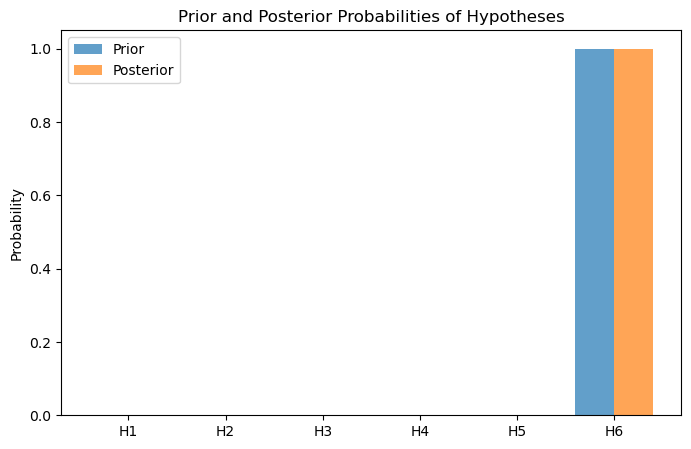

In [75]:
plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, inc_priors, width=0.4, label="Prior", alpha=0.7)
plt.bar(x + 0.2, inc_post, width=0.4, label="Posterior", alpha=0.7)

plt.xticks(x, labels)  # Set x-axis labels
plt.ylabel("Probability")
plt.title("Prior and Posterior Probabilities of Hypotheses")
plt.legend()
plt.show()

## References

Tenenbaum, J. B. (2000). Bayesian modeling of human concept learning. In S. Solla, T. Leen, & K. R. Muller (Eds.), *Advances in Neural Information Processing Systems 12* (pp 59–65). Cambridge, MA: MIT Press.

Xu, F., & Tenenbaum, J. B. (2007). Word learning as Bayesian inference. *Psychological Review, 114,* 245-272.